In [19]:
import os
import glob
import pickle
import datetime
import numpy as np
from tqdm.notebook import tqdm
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import *

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\visao_astro'

In [2]:
uniques, VisAO_science, VisAO_darks = sortData(datadir, instrument='VisAO', filesdeep='*\\*\\', returntab=True)

  0%|                                                                              | 16/33363 [00:00<03:32, 156.93it/s]

sorting individual images


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 386.74it/s]

sorting unique datasets into lists


In [3]:
# data takes a long time to sort so pickle result
filename = 'visao_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_science,outfile)
outfile.close()

filename = 'visao_uniques.pkl'
outfile = open(filename,'wb')
pickle.dump(uniques,outfile)
outfile.close()

filename = 'visao_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_darks,outfile)
outfile.close()

In [3]:
# read in pickle
infile = open('visao_science.pkl','rb')
VisAO_science = pickle.load(infile)
infile.close()

infile = open('visao_uniques.pkl','rb')
uniques = pickle.load(infile)
infile.close()

infile = open('visao_darks.pkl','rb')
VisAO_darks = pickle.load(infile)
infile.close()

In [4]:
# sorts dark fields into a subfolder in their directory named dark
VisAO_new_darks = []
for i in range(len(VisAO_darks)):
    dataset = VisAO_darks[i]
    new_darkset = []
    for dark_im in dataset:
        imname = dark_im.split('\\')[-1]
        newroot = dark_im.replace(dark_im.split('\\')[-1], 'dark\\')
        if os.path.exists(newroot):
            pass
        else:
            os.mkdir(newroot)
        newpath = newroot+imname
        try:
            os.rename(dark_im, newpath)
        except FileNotFoundError:
            pass
        new_darkset.append(newpath)
    VisAO_new_darks.append(new_darkset)

In [5]:
# introduce median combine function
def mediancombine(filelist, norm=False, sub=False):
    '''
    median combine frames, can norm for flats or not
    '''
    # gather some information about the images
    n = len(filelist)
    first_frame_data = fits.getdata(filelist[0])
    imsize_y, imsize_x = first_frame_data.shape
    # construct an empty cube with proper dimensions
    fits_stack = np.zeros((imsize_y, imsize_x, n))
    # fill cube with images in filelist
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        if sub is not False:
            subim = im-sub
        if norm is True:
            im /= np.nanmedian(im)
        fits_stack[:, :, ii] = im
    # take the median combination of the images along the
    # correct axis (we made this the 3rd axis of our image cube)
    med_frame = np.nanmedian(fits_stack, axis=2)
    return med_frame

In [45]:
# make masterdarks for each observation/exposure time
master_darks = []
for i in tqdm.tqdm(range(len(VisAO_new_darks))):
    dataset = VisAO_new_darks[i]
    # check if darks all have same exptime
    exptimes = []
    for im in dataset:
        im_expt = fits.getheader(im)['EXPTIME']
        if im_expt not in exptimes:
            exptimes.append(im_expt)
    for expt in tqdm.tqdm(exptimes):
        ims_with_expt = []
        for im in dataset:
            if fits.getheader(im)['EXPTIME'] == expt:
                ims_with_expt.append(im)
        darkim = ims_with_expt[0]
        oldheader = fits.getheader(darkim)
        oldroot = darkim.replace('dark\\'+darkim.split('\\')[-1], '..\\')
        newpath = oldroot+'MasterDark'+str(oldheader['EXPTIME'])+'s.fit'
        master_dark = mediancombine(ims_with_expt)
        master_darks.append(newpath)
        fits.writeto(newpath, master_dark, oldheader, overwrite=True)

 65%|█████████████████████████████████████████████████████                             | 11/17 [01:10<00:39,  6.58s/it]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [02:15<00:00,  7.96s/it]


In [21]:
# sorts science images into a subfolder in their directory named science
VisAO_new_science = []
for i in tqdm.tqdm(range(len(VisAO_science))):
    dataset = VisAO_science[i]
    exptimes = []
    # print('checking exp times')
    for im in tqdm.tqdm(dataset):
        try:
            im_expt = fits.getheader(im)['EXPTIME']
            if im_expt not in exptimes:
                exptimes.append(im_expt)
        except FileNotFoundError:
            pass
                
    for expt in tqdm.tqdm(exptimes):
        ims_with_expt = []
        ims_with_expt_new_path = []
        for im in dataset:
            try:
                im_expt = fits.getheader(im)['EXPTIME']
                if im_expt == expt:
                    ims_with_expt.append(im)
            except FileNotFoundError:
                pass
            

        for sci_im in ims_with_expt:
            imname = sci_im.split('\\')[-1]
            newroot = sci_im.replace(sci_im.split('\\')[-1], 'science'+str(round(expt, 5))+'s\\')
            if os.path.exists(newroot):
                # print('folder ', newroot, 'exists')
                pass
            else:
                # print('creating folder ', newroot)
                os.mkdir(newroot)
            newpath = newroot+imname
            try:
                os.rename(sci_im, newpath)
            except FileNotFoundError:
                pass
            ims_with_expt_new_path.append(newpath)
        VisAO_new_science.append(ims_with_expt_new_path)

100%|████████████████████████████████████████████████████████████████████████████| 9773/9773 [00:01<00:00, 9637.65it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [00:03<00:00, 86.37it/s]

 52%|██████████████████████████████████████████                                       | 91/175 [00:01<00:01, 58.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:02<00:00, 58.66it/s]

 18%|██████████████▋                                                                    | 3/17 [00:13<00:49,  3.56s/it]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

 59%|██████████████████████████████████████████████▉                                 | 252/429 [00:05<00:03, 53.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:09<00:00, 45.79it/s]

 31%|████████████████████████▌                                                       | 170/554 [00:03<00:07, 50.28it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 554/554 [00:10<00:00, 51.63it/s]

 33%|████████████████████████████                                                        | 1/3 [00:06<00:13,  6.56s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [00:06<00:00, 43.29it/s]

 12%|█████████▋                                                                       | 30/250 [00:00<00:05, 43.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.99it/s]

 28%|██████████████████████▏                                                         | 139/500 [00:02<00:07, 51.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.82it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 57%|████████████████████████████████████████████▊                                 | 861/1500 [00:06<00:04, 135.68it/s]


 94%|█████████████████████████████████████████████████████████████████████████     | 1405/1500 [00:14<00:01, 54.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:16<00:00, 91.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:02<00:00, 51.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 49.38it/s]

 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [02:03<00:46,  9.25s/it]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

  3%|██▎                                                                             | 86/2920 [00:02<01:01, 46.36it/s]


 15%|████████████                                                                   | 444/2920 [00:09<00:51, 47.73it/s]


 28%|█████████████████████▉                                                         | 812/2920 [00:17<00:47, 44.67it/s]


 41%|███████████████████████████████▊                                              | 1191/2920 [00:24<00:34, 49.44it/s]


 54%|██████████████████████████████████████████▏                                   | 1579/2920 [00:32<00:25, 52.29it/s]


 68%|████████████████████████████████████████████████████▋                         | 1973/2920 [00:39<00:18, 52.14it/s]


 81%|███████████████████████████████████████████████████████████████               | 2359/2920 [00:47<00:11, 47.15it/s]


 94%|█████████████████████████████████████████████████████████████████████████     | 2737/2920 [00:55<00:03, 49.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 2920/2920 [00:58<00:00, 49.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [00:03<00:00, 50.47it/s]

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


 79%|███████████████████████████████████████████████████████████████▏                | 378/479 [00:06<00:01, 58.34it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 479/479 [00:08<00:00, 55.62it/s]

 64%|██████████████████████████████████████████████████▉                             | 283/444 [00:04<00:02, 56.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [00:07<00:00, 56.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [04:15<00:00, 15.03s/it]


In [ ]:
# for now just darksub-stacking imgs to save space 
night_meds = []
for i in range(len(VisAO_new_science[0:1])):
    dataset = VisAO_new_science[i]
    # call in master dark
    first_im_path = dataset[0]
    master_folder = first_im_path.replace(first_im_path.split('\\')[-2]+'\\'+first_im_path.split('\\')[-1], '')
    master_dark_path = glob.glob(master_folder+'*MasterDark*.fit*')[0] # TODO call in expt specific dark
    master_dark = fits.getdata(master_dark_path)
    night_im = mediancombine(dataset, sub=master_dark)
    night_meds.append(night_im)

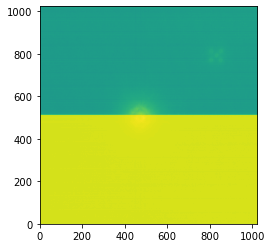

In [63]:
plt.imshow(night_meds[0], norm=ImageNormalize(stretch=LogStretch()), origin='lower')